## Deep Learning for Mortality Prediction (DLMP)

### Import packages 

In [1]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
import keras
tfkl = tf.keras.layers

### Import functions

In [2]:
import dl_functions
import lc_functions
import figure_functions
import evaluation_functions
import importlib

importlib.reload(figure_functions)
importlib.reload(lc_functions)
importlib.reload(dl_functions)
importlib.reload(evaluation_functions)

<module 'evaluation_functions' from '/Users/paigepark/Desktop/deep-mort/code/evaluation_functions.py'>

### Import data

#### State data

In [3]:
state_training = np.loadtxt('../data/state_training.txt')
state_test = np.loadtxt('../data/state_test.txt')
state_final_test = np.loadtxt('../data/state_final_test.txt')

#### Country data

In [4]:
country_training = np.loadtxt('../data/country_training.txt')
country_test = np.loadtxt('../data/country_test.txt')
country_final_test = np.loadtxt('../data/country_final_test.txt')

#### Combined data

In [3]:
combined_training = np.loadtxt('../data/combined_training.txt')
combined_test = np.loadtxt('../data/combined_test.txt')
combined_final_test = np.loadtxt('../data/combined_final_test.txt')

In [4]:
geos_key = np.load('../data/geos_key.npy')

### Train Seperate DL Models for Country and State Data

#### State Model

In [11]:
# convert data to tensors and other prep 
state_train_prepped = dl_functions.prep_data(state_training, mode="train")
state_test_prepped = dl_functions.prep_data(state_test, mode="test")
state_final_test_prepped = dl_functions.prep_data(state_final_test, mode="test")

In [12]:
# get the proper geography input dimension for model set up 
unique_vals = tf.unique(state_training[:, 0]).y
state_geo_dim = np.array(tf.size(unique_vals)).item()
state_geo_dim

50

In [12]:
# run model for states
model_state, loss_info_state = dl_functions.run_deep_model(state_train_prepped, state_test_prepped, state_geo_dim, 30)

Epoch 1/30
1000/1000 - 12s - 12ms/step - loss: 0.0134 - val_loss: 5.7132e-04 - learning_rate: 0.0010
Epoch 2/30
1000/1000 - 9s - 9ms/step - loss: 6.6791e-04 - val_loss: 1.8921e-04 - learning_rate: 0.0010
Epoch 3/30
1000/1000 - 8s - 8ms/step - loss: 3.5427e-04 - val_loss: 1.4029e-04 - learning_rate: 0.0010
Epoch 4/30
1000/1000 - 9s - 9ms/step - loss: 2.4855e-04 - val_loss: 4.5338e-04 - learning_rate: 0.0010
Epoch 5/30
1000/1000 - 8s - 8ms/step - loss: 1.9265e-04 - val_loss: 9.4141e-05 - learning_rate: 0.0010
Epoch 6/30
1000/1000 - 9s - 9ms/step - loss: 1.4986e-04 - val_loss: 2.8327e-04 - learning_rate: 0.0010
Epoch 7/30
1000/1000 - 10s - 10ms/step - loss: 1.2855e-04 - val_loss: 6.9065e-05 - learning_rate: 0.0010
Epoch 8/30
1000/1000 - 9s - 9ms/step - loss: 1.1541e-04 - val_loss: 1.9916e-04 - learning_rate: 0.0010
Epoch 9/30
1000/1000 - 10s - 10ms/step - loss: 1.1723e-04 - val_loss: 5.3315e-05 - learning_rate: 0.0010
Epoch 10/30
1000/1000 - 9s - 9ms/step - loss: 1.0045e-04 - val_loss: 1.

#### Country Model

In [ ]:
# prep data
country_train_prepped = dl_functions.prep_data(country_training, mode="train")
country_test_prepped = dl_functions.prep_data(country_test, mode="test")
country_final_test_prepped = dl_functions.prep_data(country_final_test, mode="test")

In [ ]:
# get the proper geography input dimension for model set up 
unique_vals = tf.unique(country_training[:, 0]).y
country_geo_dim = np.array(tf.size(unique_vals)).item()
country_geo_dim = country_geo_dim + 50
country_geo_dim

88

In [ ]:
# run country model
model_country, loss_info_country = dl_functions.run_deep_model(country_train_prepped, country_test_prepped, country_geo_dim, 30)

Epoch 1/30
1000/1000 - 11s - 11ms/step - loss: 0.0148 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 2/30
1000/1000 - 9s - 9ms/step - loss: 0.0017 - val_loss: 7.4688e-04 - learning_rate: 0.0010
Epoch 3/30
1000/1000 - 9s - 9ms/step - loss: 0.0011 - val_loss: 7.4013e-04 - learning_rate: 0.0010
Epoch 4/30
1000/1000 - 9s - 9ms/step - loss: 9.2474e-04 - val_loss: 2.7346e-04 - learning_rate: 0.0010
Epoch 5/30
1000/1000 - 9s - 9ms/step - loss: 7.8258e-04 - val_loss: 2.4336e-04 - learning_rate: 0.0010
Epoch 6/30
1000/1000 - 10s - 10ms/step - loss: 7.3224e-04 - val_loss: 4.5685e-04 - learning_rate: 0.0010
Epoch 7/30
1000/1000 - 10s - 10ms/step - loss: 7.5219e-04 - val_loss: 2.0720e-04 - learning_rate: 0.0010
Epoch 8/30
1000/1000 - 9s - 9ms/step - loss: 6.9120e-04 - val_loss: 3.9451e-04 - learning_rate: 0.0010
Epoch 9/30
1000/1000 - 9s - 9ms/step - loss: 6.8964e-04 - val_loss: 3.8024e-04 - learning_rate: 0.0010
Epoch 10/30
1000/1000 - 10s - 10ms/step - loss: 6.5287e-04 - val_loss: 4.6093e-04 -

### Train Combined DL Model

In [5]:
# convert combined data to tensors and other prep
combined_train_prepped = dl_functions.prep_data(combined_training, mode="train")
combined_test_prepped = dl_functions.prep_data(combined_test, mode="test")
combined_final_test_prepped = dl_functions.prep_data(combined_final_test, mode="test")

In [6]:
# get the proper geography input dimension for model set up 
unique_vals = tf.unique(combined_training[:, 0]).y
combined_geo_dim = np.array(tf.size(unique_vals)).item()
print(combined_geo_dim)

88


In [79]:
@keras.saving.register_keras_serializable()
class CustomModel(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pred_loss_tracker = keras.metrics.Mean(name="pred_loss")
        self.value_loss_tracker = keras.metrics.Mean(name="value_loss")

        self.val_pred_loss_tracker = keras.metrics.Mean(name="val_pred_loss")
        self.val_value_loss_tracker = keras.metrics.Mean(name="val_value_loss")

    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            pred, values = self(x)
            pred_loss = keras.losses.mean_squared_error(y, pred)
            mae = keras.losses.mean_absolute_error(y, pred)
            value_loss = keras.losses.mean_squared_error(mae, values)
            loss = pred_loss * 0.9 + value_loss * 0.1
        
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        self.pred_loss_tracker.update_state(pred_loss)
        self.value_loss_tracker.update_state(value_loss)

        # Return a dict mapping metric names to current value
        return {"pred_loss": self.pred_loss_tracker.result(),
                "value_loss": self.value_loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        x, y = data
        pred, values = self(x, training=False)
        pred_loss = keras.losses.mean_squared_error(y, pred)
        mae = keras.losses.mean_absolute_error(y, pred)
        value_loss = keras.losses.mean_squared_error(mae, values)

        # Update state of validation-loss tracker
        self.val_pred_loss_tracker.update_state(pred_loss)
        self.val_value_loss_tracker.update_state(value_loss)
        return {"pred_loss": self.val_pred_loss_tracker.result(),
                "value_loss": self.val_value_loss_tracker.result()}

    @property
    def metrics(self):
        return [self.pred_loss_tracker, self.value_loss_tracker, self.val_pred_loss_tracker, self.val_value_loss_tracker]

In [72]:
def create_model(geo_dim):
    # defining inputs 
    year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
    age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
    geography = tfkl.Input(shape=(1,), dtype='int32', name='Geography')
    gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')

    # defining embedding layers 
    age_embed = tfkl.Embedding(input_dim=100, output_dim=5, name='Age_embed')(age)
    age_embed = tfkl.Flatten()(age_embed)

    gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, name='Gender_embed')(gender)
    gender_embed = tfkl.Flatten()(gender_embed)

    geography_embed = tfkl.Embedding(input_dim=geo_dim, output_dim=5, name='Geography_embed')(geography)
    geography_embed = tfkl.Flatten()(geography_embed)

    # create feature vector that concatenates all inputs 
    x = tfkl.Concatenate()([year, age_embed, gender_embed, geography_embed])
    x1 = x

    # setting up middle layers 
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    # setting up output layer 
    x = tfkl.Concatenate()([x1, x])
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)
    
    v = tfkl.Dense(1, name='value')(x)

    pred = tfkl.Dense(1, activation='sigmoid', name='final')(x)

    # creating the model 
    model = CustomModel(inputs=[year, age, geography, gender], outputs=[pred, v])

    # compiling the model
    model.compile(optimizer='adam')

    return model

In [73]:
def run_deep_model(dataset_train, dataset_test, geo_dim, epochs):
    
    model = create_model(geo_dim)

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=3, verbose=0, mode="auto", 
                                                    min_delta=1e-8, cooldown=0, min_lr=0.0)]
    history = model.fit(dataset_train, validation_data=dataset_test, validation_steps=25, steps_per_epoch=1000, 
                        epochs=epochs, verbose=2)

    # loss_info = {
    #     'train_mse': history.history['loss'][-1],
    #     'val_mse': history.history['val_loss'][-1]
    # }

    tf.keras.backend.clear_session()

    return model


In [74]:
model_combined = run_deep_model(combined_train_prepped, combined_test_prepped, combined_geo_dim, 30)

Epoch 1/30
1000/1000 - 12s - 12ms/step - pred_loss: 0.0034 - value_loss: 2.6433e-04 - val_pred_loss: 3.6045e-04 - val_value_loss: 4.2624e-04
Epoch 2/30
1000/1000 - 8s - 8ms/step - pred_loss: 4.1968e-04 - value_loss: 1.4849e-04 - val_pred_loss: 4.3587e-04 - val_value_loss: 4.1968e-04
Epoch 3/30
1000/1000 - 8s - 8ms/step - pred_loss: 4.1979e-04 - value_loss: 3.4390e-05 - val_pred_loss: 4.9601e-04 - val_value_loss: 4.8090e-04
Epoch 4/30
1000/1000 - 8s - 8ms/step - pred_loss: 3.8699e-04 - value_loss: 8.5071e-05 - val_pred_loss: 7.2077e-04 - val_value_loss: 8.5094e-04
Epoch 5/30
1000/1000 - 8s - 8ms/step - pred_loss: 3.5844e-04 - value_loss: 8.6529e-05 - val_pred_loss: 3.7988e-04 - val_value_loss: 3.6524e-04
Epoch 6/30
1000/1000 - 8s - 8ms/step - pred_loss: 3.3190e-04 - value_loss: 2.7555e-04 - val_pred_loss: 6.6007e-04 - val_value_loss: 6.1782e-04
Epoch 7/30
1000/1000 - 8s - 8ms/step - pred_loss: 3.2757e-04 - value_loss: 3.6087e-06 - val_pred_loss: 2.7903e-04 - val_value_loss: 2.5137e-04
E

In [53]:
model_combined.save('value_model1.keras')

In [85]:
model_combined = keras.models.load_model('value_model1.keras', custom_objects={'CustomModel': CustomModel})

In [86]:
geo = combined_test[:, 0]
gender = combined_test[:, 1]
year = (combined_test[:, 2] - 1959) / 60
age = combined_test[:, 3]
features = (year, age, geo, gender)

pred, error = model_combined(features)
error = np.abs(error)

In [88]:
upper_bound = pred + error * 1
lower_bound = pred - error * 1
upper_bound = upper_bound[:, 0]
lower_bound = lower_bound[:, 0]
rates = combined_test[:, 4]
above = rates > lower_bound
below = rates < upper_bound
within_bounds = np.logical_and(above, below)
print(np.mean(above))
print(np.mean(below))
print(np.mean(within_bounds))

0.7414770114942528
0.9896609195402298
0.7311379310344828


0.85


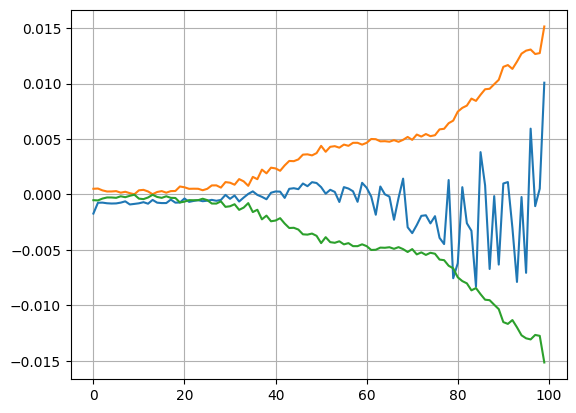

In [112]:
year_int = 2008
geo_int = 1
gender_int = 0

year = np.array([year_int], dtype=np.float32)
year = np.repeat(year[None, :], 100, axis=0)
geo = np.array([geo_int], dtype=np.int32)
geo = np.repeat(geo[None, :], 100, axis=0)
gender = np.array([gender_int], dtype=np.int32)
gender = np.repeat(gender[None, :], 100, axis=0)
age = np.array(range(100), dtype=np.int32)
age = np.reshape(age, (100, 1))
input_features = (tf.convert_to_tensor((year - 1959) / 60, dtype=tf.float32),  # Normalized year
                    tf.convert_to_tensor(age, dtype=tf.float32),  # Age
                    tf.convert_to_tensor(geo, dtype=tf.float32),  # Geography
                    tf.convert_to_tensor(gender, dtype=tf.float32))  # Gender

pred, error = model_combined(input_features)
actual_data = combined_test[(combined_test[:, 0] == geo_int) & (combined_test[:, 2] == year_int) & (combined_test[:, 1] == gender_int)]
ages = actual_data[:, 3]  # Age column
actual_rates = actual_data[:, 4]  # Mortality rate column
error = np.abs(error)

upper_bound = pred + error * 2
lower_bound = pred - error * 2
within_bounds = np.logical_and(actual_rates[:, None] < upper_bound, actual_rates[:, None] > lower_bound)
print(np.sum(within_bounds) / 100)

# plt.plot(ages, actual_rates, label='Actual rates')
# plt.plot(pred, label='Predictions')
# plt.plot(pred + error * 2, label='Upper error bound')
# plt.plot(pred - error * 2, label='Lower error bound')
# plt.legend()
# plt.ylim(0.05)
# plt.xlim(80)
plt.plot((actual_rates - pred[:, 0]))
plt.plot(error[:, 0] * 1)
plt.plot(-error[:, 0] * 1)
plt.grid()

In [141]:
model_combined, loss_info_combined = dl_functions.run_deep_model(combined_train_prepped, combined_test_prepped, combined_geo_dim, 10)

Epoch 1/10


KeyboardInterrupt: 

In [30]:
model_combined.save('model_combined.keras')

In [13]:
model_combined = keras.models.load_model('model_combined.keras')

### MSE for states only from combined model

In [ ]:
state_mse_combined = model_combined.evaluate(state_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 5.6754e-05


### MSE for countries only from combined model

In [22]:
country_mse_combined = model_combined.evaluate(country_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 2.9035e-04


### Train Lee-Carter model

In [ ]:
lc_output, lc_predictions, lc_val_mse = lc_functions.run_lc_model(train_data=combined_training, test_data=combined_test)

Skipping Geo: 74.0, Gender: 1.0 due to NaN or infinite values in m_x


In [25]:
print(lc_predictions)

[[0.00000000e+00 0.00000000e+00 2.00600000e+03 0.00000000e+00
  1.18153311e-02]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 1.00000000e+00
  8.34357926e-04]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 2.00000000e+00
  3.61102455e-04]
 ...
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.70000000e+01
  3.66874171e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.80000000e+01
  3.80324154e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.90000000e+01
  3.95598510e-01]]


### Generate Table 1: Training and Test MSEs
This table will document average MSEs (for states alone, countries alone, and total) over 5 training runs with each model (LC, deep learning seperate, deep learning joint)

In [ ]:
def compare_models(num_iterations):
    results = []
    for i in range(num_iterations):
        lc = lc_functions.run_lc_model(train_data=combined_training, test_data=combined_test)
        print(f"Lee Carter Iteration {i} Complete")

        state_model, state_only = dl_functions.run_deep_model(dataset_train=state_train_prepped, dataset_test=state_test_prepped, geo_dim=state_geo_dim, epochs=30)
        country_model, country_only = dl_functions.run_deep_model(dataset_train=country_train_prepped, dataset_test=country_test_prepped, geo_dim=country_geo_dim, epochs=30)

        ind_ave = ((state_only['val_mse']*50) + (country_only['val_mse']*37)) / 87
        seperate_dl = [state_only['val_mse'], country_only['val_mse'], ind_ave]
        print(f"Seperate DL Iteration {i} Complete")

        model_combined, loss_info_combined = dl_functions.run_deep_model(combined_train_prepped, combined_test_prepped, combined_geo_dim, epochs=30)

        state_combined = model_combined.evaluate(state_test_prepped)
        country_combined = model_combined.evaluate(country_test_prepped)
        total_combined = model_combined.evaluate(combined_test_prepped)

        combined_dl = [state_combined, country_combined, total_combined]
        print(f"Combined DL Iteration {i} Complete")

        results.append((lc, seperate_dl, combined_dl))

    return results
        

Comparison results are computationally costly to generate. Could be good to look into how Savio could help to speed this up. Commenting out for now.

In [27]:
# comparison_results = compare_models(num_iterations=1)

In [28]:
# lc_results = np.array([result[0][0] for result in comparison_results])
# seperate_dl_results = np.array([result[1] for result in comparison_results])
# combined_dl_results = np.array([result[2] for result in comparison_results])

In [29]:
# lc_avg = np.mean(lc_results, axis=0)
# seperate_dl_avg = np.mean(seperate_dl_results, axis=0)
# combined_dl_avg = np.mean(combined_dl_results, axis=0)

In [30]:
# average_results = np.array([lc_avg, seperate_dl_avg, combined_dl_avg])

# # Multiply each value by 10^4 for table clarity
# average_results = [[value * 10**4 for value in row] for row in average_results]
# average_results_rounded = np.round(average_results, 3).T
# print(average_results_rounded)

In [31]:
# from tabulate import tabulate

# column_labels = ["Lee Carter Model", "Separate DL Models", "Combined DL Model"]
# row_labels = ["State Test MSE", "Country Test MSE", "Weighted Average of MSEs"]

# table_data = [[row_labels[i]] + list(average_results_rounded[i]) for i in range(len(row_labels))]

# latex_table = tabulate(table_data, headers=["Test MSE by Model"] + column_labels, tablefmt="latex")


In [32]:
# print(latex_table)

#### Generate a few examples of fit by model 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

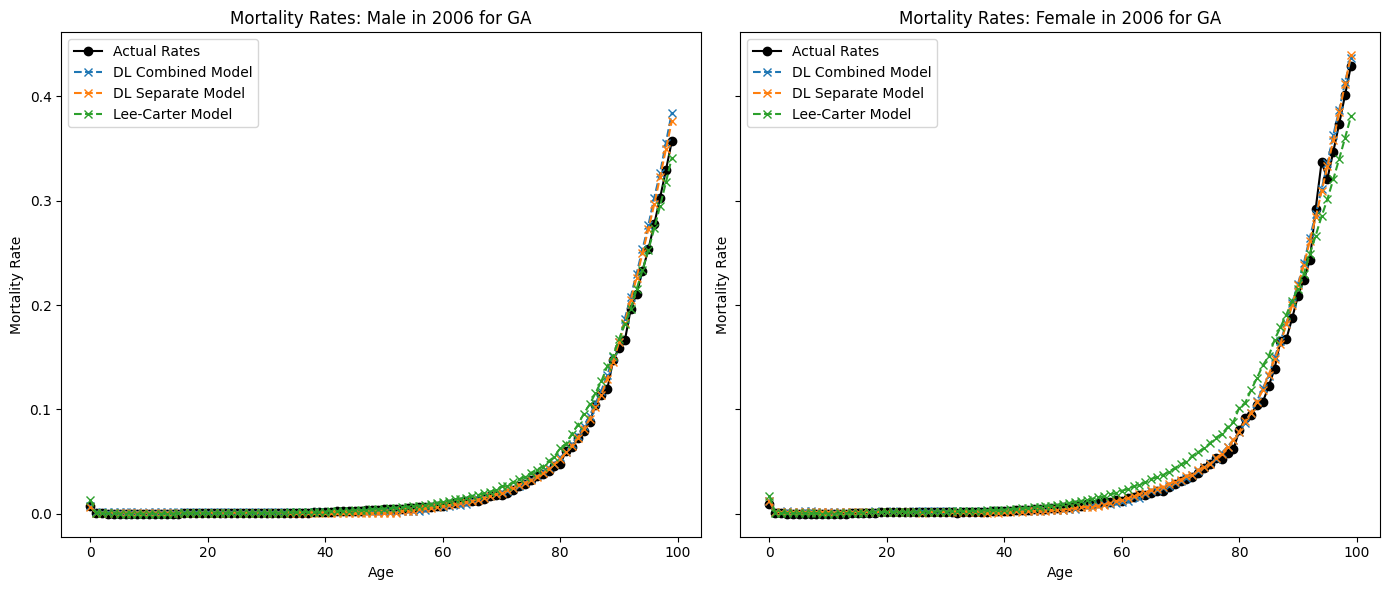

In [ ]:
figure_functions.plot_mort_predictions(geo=9, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=combined_test, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

#### Plot difference from actual rates by year and age 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

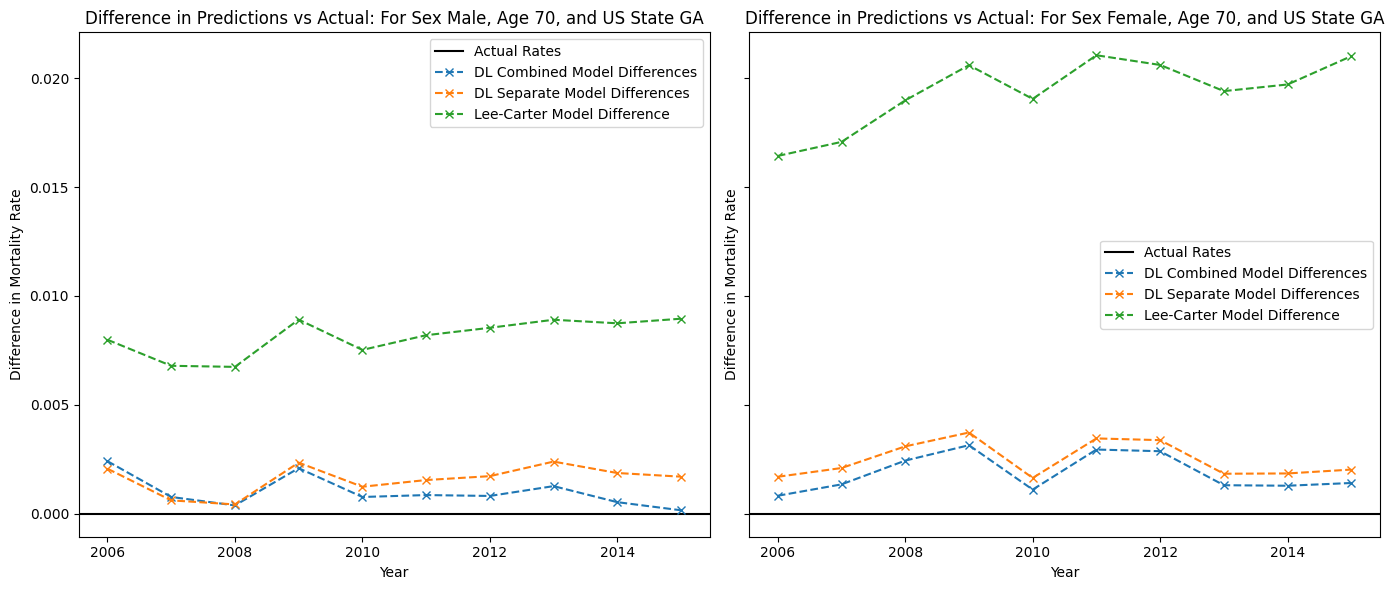

In [ ]:
figure_functions.plot_pred_diff_by_year(geo=9, year_range=np.arange(2006, 2016), age=70, genders=[0,1], data=combined_test, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

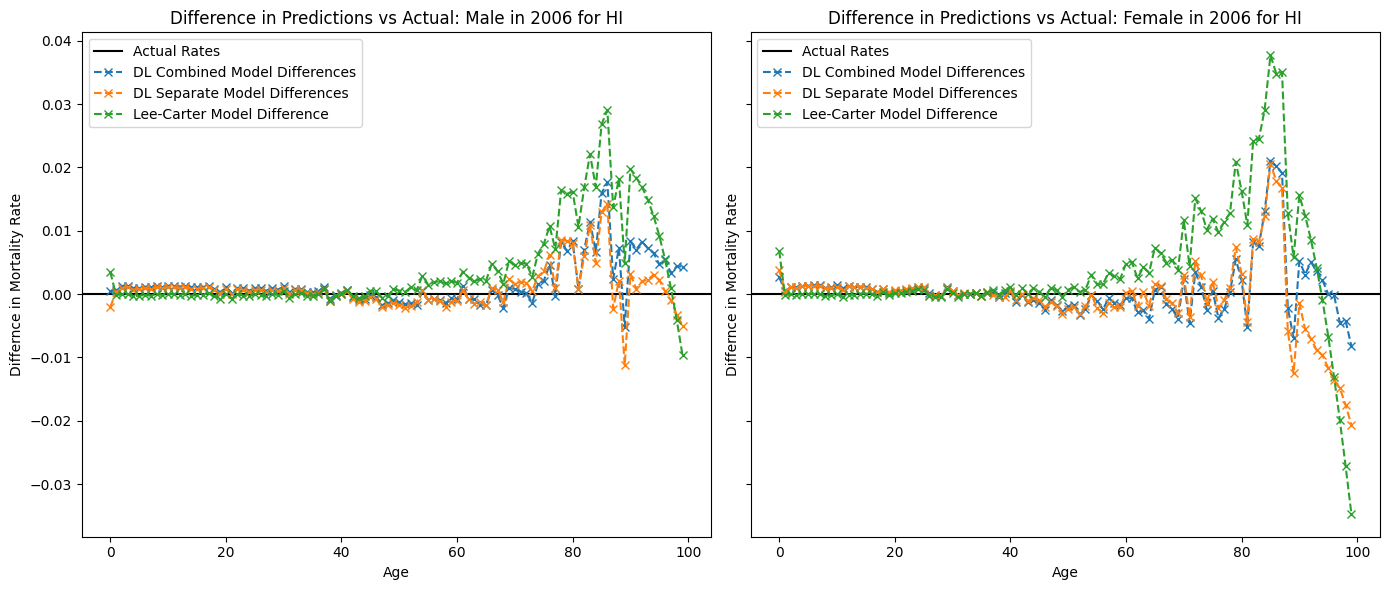

In [ ]:
figure_functions.plot_pred_diff_by_age(geo=10, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=combined_test, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

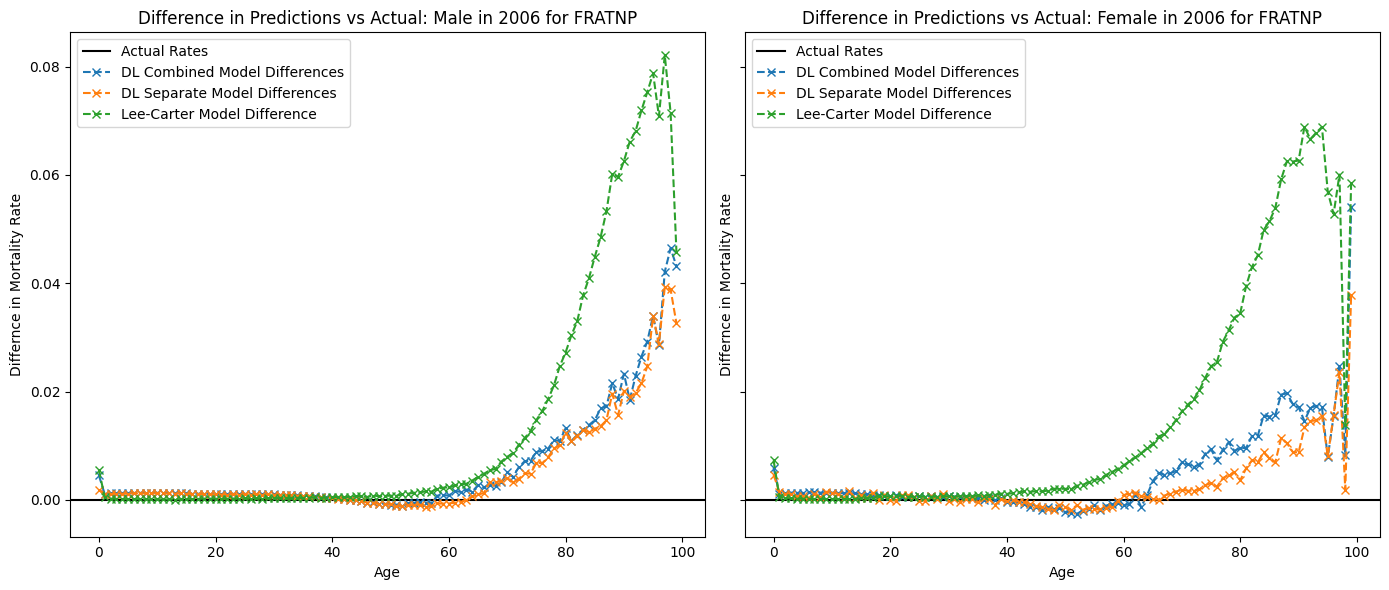

In [ ]:
figure_functions.plot_pred_diff_by_age(geo=62, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=combined_test, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_country
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

#### Generate Subgroup MSE Barplots

Generate predictions for whole validation set, then filter sample and do MSE calculation

In [ ]:
lc_mses = evaluation_functions.calculate_mse_by_category_lc(lc_predictions, combined_test, feature_index=0) # 0 is geo in test data

In [42]:
print(lc_mses)

{0: 0.000505086383750791, 1: 0.00016727167949998496, 2: 0.00013923665598574074, 3: 9.686659549858767e-05, 4: 0.0002810058493022958, 5: 0.00016452314690351076, 6: 0.00025939602799368155, 7: 0.00022764825446593807, 8: 0.00014576977033699595, 9: 0.00016182086562969986, 10: 0.00015821085136177046, 11: 0.00014853081812886832, 12: 0.0003156142631741746, 13: 0.00019302393083707746, 14: 0.0001729222263211934, 15: 0.00015014476009328172, 16: 0.0001155720095863507, 17: 0.00018536425581226634, 18: 0.00019493606582454047, 19: 0.0002927229395554671, 20: 0.00025740618632561657, 21: 0.00019003569755644505, 22: 0.0002077788732956386, 23: 0.00022414136525277805, 24: 0.0001838757631459525, 25: 0.00015646026855760937, 26: 0.00016012290863475103, 27: 0.00012077508287191175, 28: 0.0002790325426898022, 29: 0.0003072367419880135, 30: 0.00013000781525188314, 31: 0.0003658689690360428, 32: 0.00013219737033016144, 33: 0.00018677705220290737, 34: 0.0002134848647383149, 35: 9.58291074067974e-05, 36: 0.00015486434

In [ ]:
geo_mses_combined = evaluation_functions.calculate_mse_by_category(combined_test_prepped, model_combined, feature_index=2) # 2 is geo in combined_test_prepped

In [ ]:
geos_mses_separate_states = evaluation_functions.calculate_mse_by_category(state_test_prepped, model_state, feature_index=2) # 2 is geo in combined_test_prepped

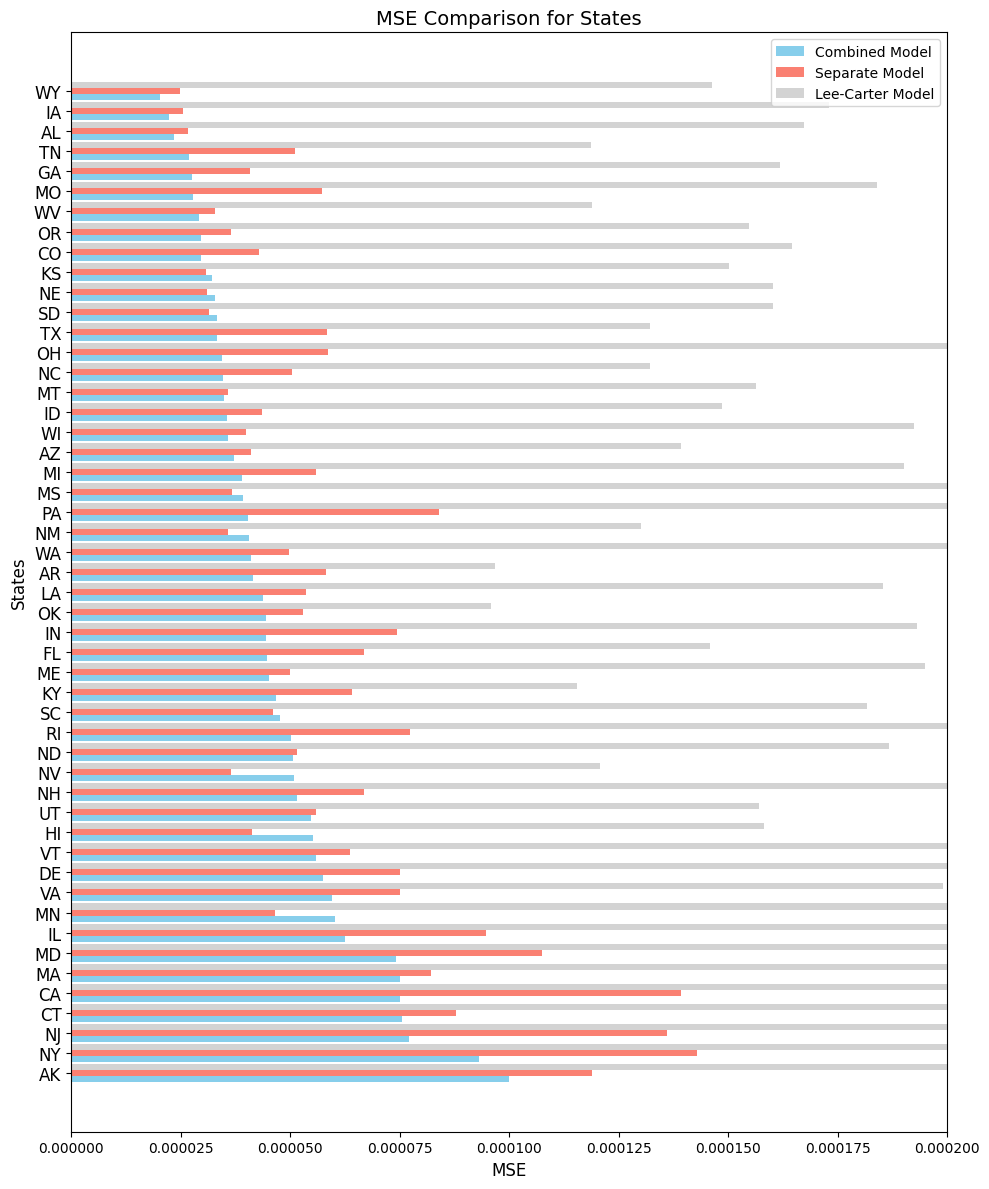

In [91]:
fig, ax = figure_functions.plot_mse_section(mse_by_category1=geo_mses_combined, mse_by_category2=geos_mses_separate_states, mse_by_category3=lc_mses, 
                                  category_labels=geos_key, plot_type="States", start=0, end=49, x_max=0.0002)

fig.savefig("mse_states.pdf", format="pdf")
plt.show()
plt.close()    

In [ ]:
geos_mses_separate_countries = evaluation_functions.calculate_mse_by_category(country_test_prepped, model_country, feature_index=2)

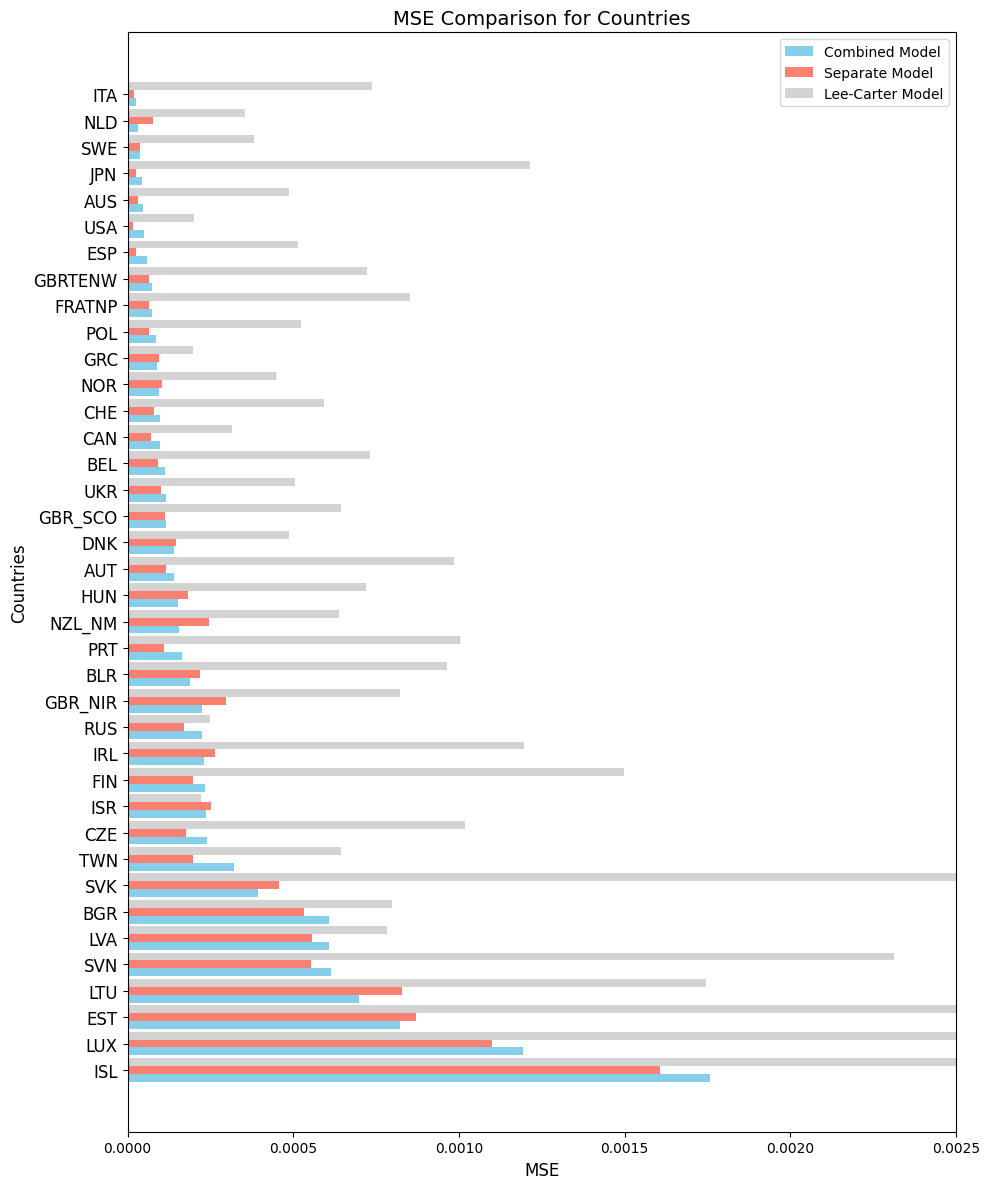

In [93]:
figure_functions.plot_mse_section(geo_mses_combined, geos_mses_separate_countries, lc_mses, geos_key, "Countries", start=50, end=87, x_max=0.0025)

plt.savefig("mse_countries.pdf", format="pdf")
plt.show()
plt.close()  

Save scores by country for each model

In [52]:
mses_by_country = pd.DataFrame({'Lee-Carter': lc_mses, 'Deep Learning': geo_mses_combined})
key = {int(num): label for label, num in geos_key}
mses_by_country.index = mses_by_country.index.map(key)
mses_by_country.to_csv('mses_by_country.csv', index=True)

Plot MSEs by age

In [106]:
import evaluation_functions

importlib.reload(evaluation_functions)

<module 'evaluation_functions' from '/Users/paigepark/Desktop/deep-mort/code/evaluation_functions.py'>

In [ ]:
lc_mses_age = evaluation_functions.calculate_rmae_by_category_lc(lc_predictions, combined_test, feature_index=3) # 3 is age in test_data
geo_mses_combined = evaluation_functions.calculate_rmae_by_category(combined_test_prepped, model_combined, feature_index=1) # 1 is age in combined_test_prepped

2024-12-13 18:56:00.714878: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
print(lc_mses_age)
print(geo_mses_combined)

{0: 6.177341309118725e-05, 1: 4.6803850914576817e-07, 2: 1.572998060886107e-07, 3: 8.807875698339975e-08, 4: 6.083676463464528e-08, 5: 4.462440098889251e-08, 6: 3.903256501867469e-08, 7: 6.712435753451548e-08, 8: 2.9044756774523775e-08, 9: 2.5330798129520558e-08, 10: 2.5868278937407852e-08, 11: 2.2520416775671308e-08, 12: 2.6171626966450826e-08, 13: 3.429069230323707e-08, 14: 5.092053541276916e-08, 15: 8.336407639118106e-08, 16: 1.41129025790359e-07, 17: 1.901592346665455e-07, 18: 2.4339878549602526e-07, 19: 2.2879000109858765e-07, 20: 2.128699113480576e-07, 21: 1.9848173996752153e-07, 22: 1.870685241430759e-07, 23: 1.8184175318659482e-07, 24: 1.625784799163104e-07, 25: 1.716220992586674e-07, 26: 1.666197686155849e-07, 27: 1.7808203093409096e-07, 28: 1.956140118284182e-07, 29: 1.849240494382458e-07, 30: 2.2122652361427223e-07, 31: 2.4162814020369147e-07, 32: 2.575271034175392e-07, 33: 3.0938026443850974e-07, 34: 3.265358082312878e-07, 35: 3.81886470115902e-07, 36: 4.250242177833067e-07

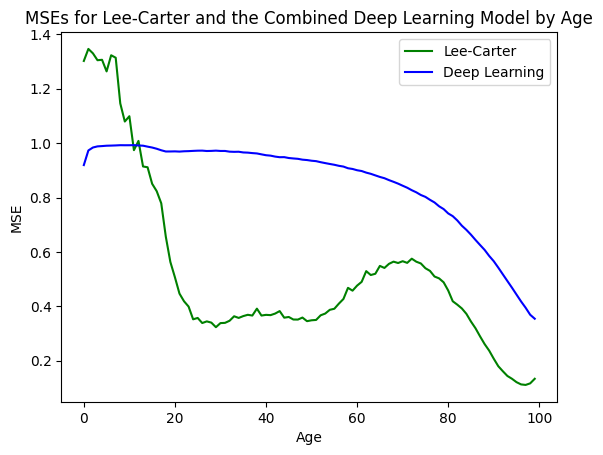

In [108]:
# Sort dictionaries by keys (in case keys are not in order)
keys1, values1 = zip(*sorted(lc_mses_age.items()))
keys2, values2 = zip(*sorted(geo_mses_combined.items()))

# Plot the data
plt.plot(keys1, values1, label="Lee-Carter", color='green')
plt.plot(keys2, values2, label="Deep Learning", color='blue')

# Add labels, legend, and title
plt.xlabel("Age")
plt.ylabel("MSE")
plt.title("MSEs for Lee-Carter and the Combined Deep Learning Model by Age")
plt.legend()

# Show the plot
plt.show()